# NFC extraction testing

Short tests of script to extract NFCs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
import pandas as pd
from pathlib import Path
import random

Load the document which describes the upper and lower frequency limits for bandpassing as well as the approximate duration of the call

In [2]:
freq_limits = pd.read_csv("../freqs_and_durations_manual_edits.csv")
freq_limits.head()

,code,low_freq,high_freq,approx_duration,median_duration,approx_minus_median_duration
0,CANG,0.1,10000,0.10,0.093,0.007
1,GWTE,0.1,5000,0.10,0.075,0.025
2,BLSC,1000.0,4000,0.50,0.272,0.228
3,LTDU,0.1,10000,0.10,0.082,0.018
4,BBCU,0.1,5000,0.05,0.042,0.008


Load the table which describes the pairings between annotation files and audio files

In [3]:
tables_to_filenames = pd.read_csv("../1_nfc_annotation_prep/annotation_audio_pairs.csv", index_col='annotation_file').to_dict()['audio_file']

## Functions for creating spectrograms

Formatting function to nicely format ticks for frequency (y axis) and time (x axis)

In [4]:
def freq_reformatter(tick_val_hertz, pos):
    """
    Input: float value in Hertz, e.g. 10000.0
    Output: formatted string in kHz, e.g. '10'
    """
    val_khz = tick_val_hertz/1000
    str_format = "%.0f" % val_khz
    if len(str_format) < 2:
        str_format = str_format + '  '
    return str_format

In [5]:
def sec_reformatter(tick_val_sec, pos):
    """
    Input: float value in seconds, e.g. 0.15
    Output: formatted string in milliseconds, e.g. '150'
    """
    val_ms = tick_val_sec*1000
    return "%.0f" % val_ms
    

Function to save nice-looking spectrograms (using the functions above for formatting)

In [6]:
plt.rcParams['figure.dpi'] = 300

def save_or_plot_spectrogram(s, filename, duration, save=True, pixels_tall=133, short_spec=True):
    """Create and save an NFC spectrogram
    
    Inputs:
        s: opensoundscape.spectrogram.Spectrogram object
        filename: where to save the file
        duration: duration of the spectrogram
        save: whether or not to save the file. If not saved, just plots the fig
    """
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    if short_spec:
        plt.subplots(figsize=(duration*pixels_tall*5*px, pixels_tall*px))
    else:
        plt.subplots(figsize=(duration*pixels_tall*2*px, pixels_tall*px))
        
    # plt.subplots(figsize=(duration*30, 5))
    
    plot = s.plot(inline=False)
    s.plot(inline=False)
    ax = plt.gca()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="y", direction="in", pad=-4, length=1.3, width=0.2, labelsize=2)
    ax.tick_params(axis="x", direction="in", pad=-3, length=1.3, width=0.2, labelsize=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(x=0)
    
    if short_spec:
        ax.set_xticks(np.arange(0, duration-0.025, 0.05)[1:])
    else:
        ax.set_xticks(np.arange(0, duration-0.25, 0.5)[1:])
        
    ax.set_yticks([2000, 4000, 6000, 8000, 10000])
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.2)
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(sec_reformatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(freq_reformatter))
    if save:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    plt.close()



## Create table of all annotations and subsample it

This allows us to take annotations from a random set of files.

### Create table of annotations from all annotation files

This step takes a while...

In [7]:
keys = list(tables_to_filenames.keys()) 
all_annots_list = []

# Loop through the files and extract annotations
for txt_file_name in keys:
    txt_file_path = Path("kearney-nfc_annotations_cleaned").joinpath(txt_file_name)
    audio_file = tables_to_filenames[txt_file_name]
    location_metadata = str(Path(audio_file).parent).strip('/bgfs/jkitzes/ter38/data/kearney-nfc')
    
    # Loop through all annotations in the file
    df = pd.read_csv(Path("../../annotations").joinpath(txt_file_path), sep='\t')
    df["Source"] = txt_file_name
    all_annots_list.append(df)

all_annots_df = pd.concat(all_annots_list)
all_annots_df.reset_index(drop=True, inplace=True)

### Select a subset of the annotations for each species

Remove unknowns

In [8]:
no_qs = all_annots_df[all_annots_df["Alpha code"] != '?']
shuffled = no_qs.sample(frac=1, random_state=42)

Calls that we've decided should be excluded due to quality, etc.

In [9]:
exclusions = pd.read_csv("exclusions.csv").filename_no_extension.tolist()
exclusions

['SWWB_20151007_190300.txt',
 'BERI1-20181023_185800.txt',
 'BERI1-20181108_173700.txt',
 'BERI1-20181104_174100.txt']

Get the indices of needed annotations

Takes a while...

In [10]:
code_counts = {}
max_samples = 30
idxs = []
for idx, row in shuffled.iterrows():
    code = row["Alpha code"] 
    if row.Source in exclusions:
        continue
    elif code not in code_counts.keys():
        code_counts[code] = 1
        idxs.append(idx)
    elif code_counts[code] >= max_samples:
        continue
    else:
        code_counts[code] += 1
        idxs.append(idx)
idxs.sort()

In [11]:
len(idxs)

2685

In [12]:
idxs[:5]

[80, 268, 292, 397, 412]

Subset those indices from the main table.

In [13]:
sampled_calls = all_annots_df.iloc[idxs]
sampled_calls.head()

,Begin time (s),End time (s),Low freq (hz),High freq (hz),Order,Family,Genus,Species,Alpha code,Source
80,28851.339,28851.467,6000.0,11000.0,PASSERIFORMES,PASSERELLIDAE,ZONOTRICHIA,ALBICOLLIS,WTSP,A2AR1_20140512_211200.txt
268,27469.419,27469.472,6000.0,11000.0,PASSERIFORMES,PASSERELLIDAE,JUNCO,HYEMALIS,DEJU,A2AR1_20140521_212400.txt
292,6650.332,6650.403,5257.1,11000.0,PASSERIFORMES,PASSERELLIDAE,SPIZELLA,PALLIDA,CCSP,A2AR1_20140522_212500.txt
397,9160.960,9161.013,6000.0,11000.0,PASSERIFORMES,PARULIDAE,GEOTHLYPIS,PHILADELPHIA,MOWA,A2AR1_20140602_213700.txt
412,9428.785,9428.890,6000.0,11000.0,PASSERIFORMES,CARDINALIDAE,PASSERINA,CYANEA,INBU,A2AR1_20140604_213900.txt


## Extraction!

### Spectrogram creation parameters

In [17]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [20]:
# Spectrogram creation parameters
sample_rate = 24000 # What many of the source files are to start with
window_samples = 256
overlap_samples = int(window_samples*0.9)
window_type = 'blackman'
decibel_limits = (-80, 0)

# Denoising parameters
denoise_quantile=0.8
bandpass = True
bp_order = 4

# How many spectrograms to create and where to save them
max_num_examples = 30
if is_notebook():
    create_audio = False
    save_audio = False
    save_long_spectrogram = False
    save_short_spectrogram = False

else:
    create_audio = True
    save_audio = True
    save_long_spectrogram = True
    save_short_spectrogram = True

# Recording length information
buffer_long_recording_seconds = 1
buffer_short_recording_multiplier = 1

In [15]:
def find_segment_start_and_duration(
    begin, end, 
    final_duration=None,
    buffer_length=None,
    buffer_percent=None,
    species_call_duration=None
):
    
    """A function for finding the start and duration of recordings
    
    If final_duration is not used, then species_call_duration must be
    used along with either buffer_length or buffer_percent
    
    Inputs:
        begin: annotated begin of call
        end: annotated end of call:
        final_duration: desired final duration - 
            centers the call within a fixed-length recording 
        buffer_length: desired absolute length of buffer - 
            center the call with a fixed amount of sound before and after
            the call (total recording length varies based on species call duration)
        buffer_percent: desired percentage of species call duration - 
            centers the call with a buffer of sound 
            determined as a percentage of the species call duration
            
    Outputs:
        start: start time of recording
        duration: duration of recording
    """
    center = (end + begin)/2
    
    # Center the call within 
    if final_duration:
        duration = float(final_duration)
        start = center - duration/2
        return start, duration
    
    # Error checking
    elif not (species_call_duration and (buffer_percent or buffer_length)):
        raise ValueError("If no final_duration, must include species_call_duration and either buffer_percent or buffer_length")
        
    # Add a fixed-length buffer before and after the estimated call length
    elif buffer_length:
        buffer = float(buffer_length)
    
    # Add a percentage buffer before and after the estimated call length
    else:
        buffer = float(species_call_duration) * float(buffer_percent)
        
    start = center - species_call_duration/2 - buffer
    duration = species_call_duration + buffer*2
    return start, duration

print(
    find_segment_start_and_duration(2.5, 3.5, final_duration = 6),
    find_segment_start_and_duration(11, 19, buffer_length=1, species_call_duration=8),
    find_segment_start_and_duration(3, 5, buffer_percent=0.5, species_call_duration=2)
)

(0.0, 6.0) (10.0, 10.0) (2.0, 4.0)


### Create and save spectrograms and audio

Output for each of the sampled annotations is named after the original clip name, plus the following extensions:
* `.wav` - bandpassed wav for long segment (long enough that listener's ear can adjust to noise before sound)
* `.jpg` - bandpassed jpg for long segment
* `_display.jpg` - jpg for long segment, bandpassed but not denoised
* `_display_denoised.jpg` - jpg for long segment, bandpassed and denoised.

A2AR1_20140512_211200_PASSERIFORMES_PASSERELLIDAE_ZONOTRICHIA_ALBICOLLIS_WTSP_28851.339_28851.467


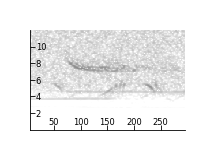

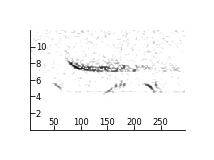

A2AR1_20140521_212400_PASSERIFORMES_PASSERELLIDAE_JUNCO_HYEMALIS_DEJU_27469.418999999998_27469.472


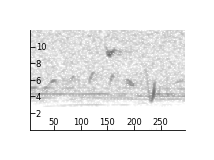

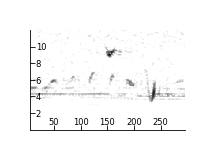

A2AR1_20140522_212500_PASSERIFORMES_PASSERELLIDAE_SPIZELLA_PALLIDA_CCSP_6650.331999999999_6650.403


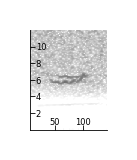

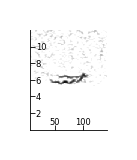

A2AR1_20140602_213700_PASSERIFORMES_PARULIDAE_GEOTHLYPIS_PHILADELPHIA_MOWA_9160.96_9161.013


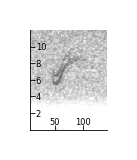

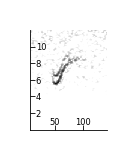

A2AR1_20140604_213900_PASSERIFORMES_CARDINALIDAE_PASSERINA_CYANEA_INBU_9428.785_9428.89


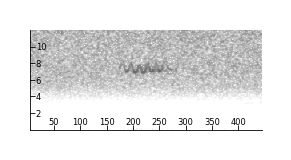

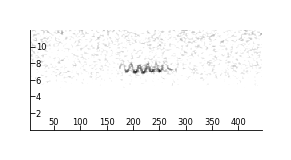

A2AR1_20140607_214200_PASSERIFORMES_PASSERELLIDAE_AMMOSPIZA_NELSONI_NESP_19497.243000000002_19497.321


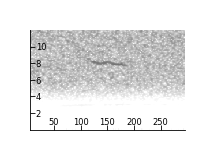

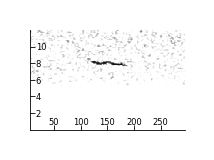

A2AR1_20140812_210300_PASSERIFORMES_TYRANNIDAE_EMPIDONAX_FLAVIVENTRIS_YBFL_16863.904_16863.957


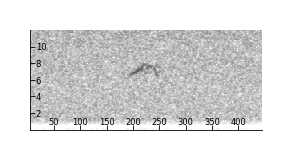

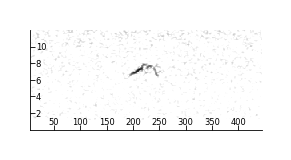

In [21]:
media_path = Path("../../media")
media_path.mkdir(exist_ok=True)
metadata = []

# Loop through the files and extract annotations
for idx, row in sampled_calls.reset_index(drop=True).iterrows():
    begin, end, low, high, order, family, genus, species, alpha, source = row.to_list()
    txt_file_path = Path("/ihome/jkitzes/ter38/nfcs2/assets/annotations/kearney-nfc_annotations_cleaned").joinpath(source)
    audio_file = tables_to_filenames[source]
    location_metadata = str(Path(audio_file).parent).strip('/bgfs/jkitzes/ter38/data/kearney-nfc')
    
    # Create the filename containing the info about the call
    bp_low, bp_high, approx_duration = freq_limits.query("code == @alpha")[['low_freq', 'high_freq', 'approx_duration']].values[0]
    if bp_low == 0:
        bp_low = 0.1
    file_info = [order, family, genus, species, alpha, str(begin), str(end)]
    dirname = media_path.joinpath(alpha)
    dirname.mkdir(exist_ok=True)
    filename = '_'.join([txt_file_path.stem, *file_info])

    print(filename)

    # Create a longer audio segment and spectrogram to save
    center = (end + begin)/2
    if create_audio:
        audio_dirname = dirname.joinpath('audio')
        audio_dirname.mkdir(exist_ok=True)
        long_seg_start, long_seg_dur = find_segment_start_and_duration(
            begin, end,
            buffer_length=buffer_long_recording_seconds,
            species_call_duration=approx_duration)
        long_segment = Audio.from_file(audio_file, sample_rate=sample_rate, offset=long_seg_start, duration=long_seg_dur)
        
        # Bandpass samples
        if bandpass:
            long_segment = long_segment.bandpass(bp_low, bp_high, order=bp_order)

        # Normalize samples
        neg_3_db = 0.7080078
        multiplier = neg_3_db / max(abs(long_segment.samples))
        long_segment.samples = long_segment.samples * multiplier

        if save_audio:
            audio_filename = str(audio_dirname.joinpath(filename)) + '.wav'
            long_segment.save(audio_filename)
            s = Spectrogram.from_audio(
                long_segment, window_samples=window_samples, overlap_samples=overlap_samples, decibel_limits=decibel_limits, window_type=window_type)
            spectrogram_dirname = dirname.joinpath('spectrograms')
            spectrogram_dirname.mkdir(exist_ok=True)
            spectrogram_filename = str(spectrogram_dirname.joinpath(filename)) + '.jpg'
            save_or_plot_spectrogram(s, filename=str(spectrogram_filename), duration=long_seg_dur, save=save_long_spectrogram, short_spec=False)


    # Save some info about the file
    metadata.append([location_metadata, txt_file_path.stem, *file_info, long_seg_start])

    # Create a shorter spectrogram to show on website
    short_seg_start, short_seg_dur = find_segment_start_and_duration(
        begin, end,
        buffer_percent = buffer_short_recording_multiplier,
        species_call_duration=approx_duration)
    
    short_segment = Audio.from_file(audio_file, sample_rate=sample_rate, offset=short_seg_start, duration=short_seg_dur)
    
    # Normalize samples
    neg_3_db = 0.2#0.7080078
    multiplier = neg_3_db / max(abs(short_segment.samples))
    short_segment.samples = short_segment.samples * multiplier
    
    if bandpass:
        short_segment = short_segment.bandpass(bp_low, bp_high, order=bp_order)

    s = Spectrogram.from_audio(
        short_segment, window_samples=window_samples, overlap_samples=overlap_samples, decibel_limits=decibel_limits, window_type=window_type)
    
    spectrogram_dirname = dirname.joinpath('spectrograms')
    spectrogram_dirname.mkdir(exist_ok=True)
    spectrogram_filename_regular = str(spectrogram_dirname.joinpath(filename)) + '_display.jpg'
    spectrogram_filename_denoise = str(spectrogram_dirname.joinpath(filename)) + '_display_denoise.jpg'
    
    save_or_plot_spectrogram(s, filename=str(spectrogram_filename_regular), duration=short_seg_dur, save=save_short_spectrogram)
    
    quantile = np.quantile(s.spectrogram, q=denoise_quantile)
    denoised_spec = s.limit_db_range(quantile, 0).min_max_scale((-80, -3))
    save_or_plot_spectrogram(
        denoised_spec,
        filename=str(spectrogram_filename_denoise), duration=short_seg_dur, save=save_short_spectrogram
    )
    
    if is_notebook():
        if idx>5:
            break

## Save record of clips

In [22]:
metadata_df = pd.DataFrame(metadata, columns=[
    'project', 'source_clip', 'order', 'family', 'genus', 'species', 'alpha_code',
    'annotation_start_time', 'annotation_end_time', 'audio_clip_start_time'])
metadata_df.to_csv("clip_metadata.csv")

In [24]:
if not is_notebook():
    quit()

In [25]:
!jupyter nbconvert --to python nfc_extraction_testing.ipynb

[NbConvertApp] Converting notebook nfc_extraction_testing.ipynb to python
[NbConvertApp] Writing 13861 bytes to nfc_extraction_testing.py
